In [26]:
# initial dataframe from the cleaned data in silver layer
import pandas as pd
from pathlib import Path

silver_path = Path.cwd() / 'LAPES-Data-Challenge-Predictive-Analytics-System'/ 'data' / 'silver' / 'creditcard_fraud_cleaned.parquet'

df = pd.read_parquet(silver_path)
print(df.shape)
df.head(3)

(283726, 31)


,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [27]:
# splitting dataset in X(independent features) and y (target class)

X = df.drop(columns='class')
y = df['class']
(y.value_counts()/y.shape[0])*100

,count
class,
0,99.83329
1,0.16671


In [28]:
# all the dataset is already scaled with pca transform, except for time and amount
# so before splitting and training the dataset,let's scale:
# time using minMaxscaler, which is standard
# amount using robustScaler, to better treat the significant rigth skewness and outliers

from sklearn.preprocessing import MinMaxScaler, RobustScaler
time_scaler = MinMaxScaler()
amount_scaler = RobustScaler()
X['time_scaled'] = time_scaler.fit_transform(X[['time']])
X['amount_scaled'] =amount_scaler.fit_transform(X[['amount']])
X[['amount_scaled','time_scaled']].describe()

,amount_scaled,time_scaled
count,283726.000000,283726.000000
mean,0.924387,0.548701
std,3.482123,0.274787
min,-0.305938,0.000000
25%,-0.228063,0.313699
50%,0.000000,0.490141
75%,0.771937,0.806160
max,356.962314,1.000000


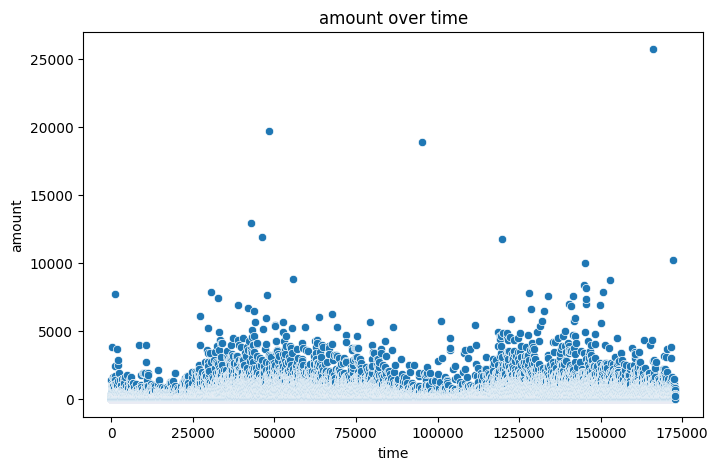

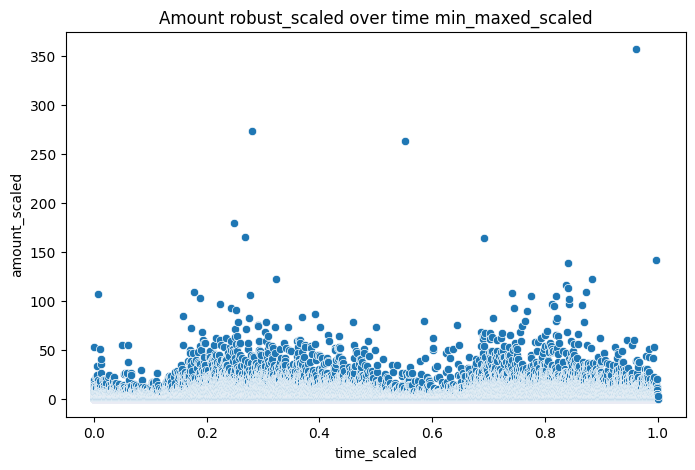

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5))
sns.scatterplot(data = X, x='time', y='amount')
plt.title('amount over time')
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data = X, x='time_scaled', y='amount_scaled')
plt.title('Amount robust_scaled over time min_maxed_scaled')
plt.show()


In [30]:
# splitting the data in training and testing, using stratify to keep the proportions and not bias the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)

In [31]:
# lets check the data splitting (this could be a function in the ML pipeline) (still simillar proportion)
print('how many frauds and non frauds in the test split\n',y_train.value_counts())
print()
print((y_train.value_counts()/y_train.shape[0])*100)

how many frauds and non frauds in the test split
 class
0    226602
1       378
Name: count, dtype: int64

class
0    99.833466
1     0.166534
Name: count, dtype: float64


In [32]:
# as this is a binary classification problem (it has two classes, positive, fraud, and negative, non-fraud)
# a logistic classifier is more apropriate
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(class_weight='balanced',random_state=11037, max_iter=400)

In [33]:
# preparing the training data
X_train = X_train.drop(columns=['time','amount'])
X_train.head(3)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,time_scaled,amount_scaled
135247,1.054342,-0.087636,0.019529,1.356912,0.041340,0.632841,-0.299389,0.214484,0.922176,-0.748573,...,-0.103343,-0.109046,-0.283825,-0.992615,0.705312,-0.190916,0.072476,0.049564,0.470988,0.769990
119524,-0.368739,1.120188,1.423466,0.142463,-0.154841,-1.170389,0.716753,-0.084979,-0.391527,-0.509284,...,-0.242758,-0.643937,0.034086,0.655165,-0.209052,0.052170,0.243950,0.101414,0.437925,-0.222639
11983,1.185781,-0.319100,1.012557,-0.562518,-0.959668,-0.304080,-0.728813,0.022061,3.101525,-1.499550,...,-0.128650,0.136658,-0.003913,0.037572,0.400203,-0.696638,0.081341,0.027359,0.120486,-0.141149


## 🧠 Why Logistic Regression for the Baseline?
Logistic Regression is a simple, interpretable model that gives us a **baseline** for detecting fraud.
It's useful for benchmarking because:

- It requires minimal hyperparameter tuning.
- Its coefficients can indicate feature importance.
- However, **Logistic Regression is sensitive to feature scaling**, so we preprocess `time` and `amount`.

---

## ⚠️ Class Imbalance in Fraud Detection
The dataset is **highly imbalanced**:
- Class 0 (Non-Fraud): ~99.8%
- Class 1 (Fraud): ~0.2%

This means **accuracy** is a **bad metric** (a model predicting "no fraud" every time would still be right 99.8% of the time). Instead, we use metrics that focus on the minority class.

---

## 📏 Key Metrics for Imbalanced Data
| Metric            | Why It Matters                                                        |
|--------------------|------------------------------------------------------------------------|
| **Precision**      | Of all predicted fraud cases, how many were correct?                 |
| **Recall (Sensitivity)** | Of all actual fraud cases, how many did we detect?                  |
| **F1-score**       | Harmonic mean of Precision and Recall (balances false positives and negatives). |
| **ROC AUC**        | Measures model's ability to separate classes across thresholds.      |
| **PR AUC**         | Precision-Recall AUC focuses on the minority class (more informative for imbalanced data). |
| **Balanced Accuracy** | Adjusts accuracy to account for class imbalance.                  |

We’ll compute all of these using cross-validation.

In [59]:
# lets make predictions with cross validate and stratified k-fold
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import (
    make_scorer,
    precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
)

# define scorers
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',  # threshold=0.5
    'recall': 'recall',        # threshold=0.5
    'f1': 'f1',                # threshold=0.5
    'roc_auc': 'roc_auc',      # needs probabilities for it to be based on all threshold
    'pr_auc': 'average_precision',  # needs probabilities
    'balanced_accuracy': 'balanced_accuracy',
}

# stratified CV to preserve fraud/non-fraud ratio in all folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11037)

# perform cross-validation
cv_results = cross_validate(
    log_clf,
    X_train, y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False,

)
results_df = pd.DataFrame(cv_results).mean()

In [60]:
results_df

,0
fit_time,3.899359
score_time,0.109260
test_accuracy,0.975553
test_precision,0.059330
test_recall,0.912807
test_f1,0.111358
test_roc_auc,0.977851
test_pr_auc,0.761891
test_balanced_accuracy,0.944232


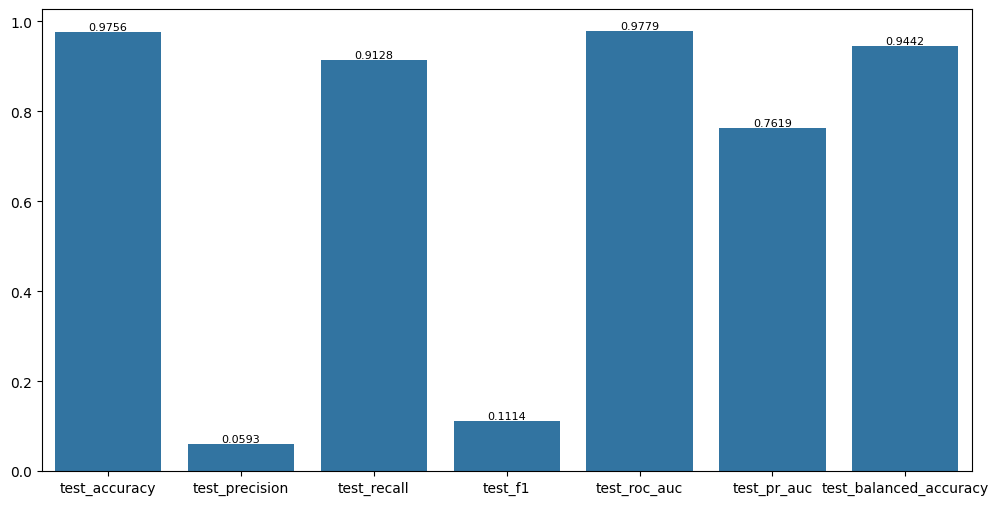

In [54]:
plt.figure(figsize=(12,6))
base_model_scores_barplot = sns.barplot(results_df.loc['test_accuracy':])


for patch in base_model_scores_barplot.patches:
    height = patch.get_height()
    if height > 0:
        base_model_scores_barplot.annotate(f'{height:.4f}',  # formatting
            (patch.get_x() + patch.get_width() / 2, height), # setting each coordinate to be on the patch
            ha='center', va='bottom', fontsize=8, rotation=0) # position related to the patch cordinate, right above and center


plt.show()

In [36]:
log_clf.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 400,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 11037,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

# Lets remember the features most correlated to target class (fraud)
this will be the base for:

feature selection

feature engineering

feature dropping

In [37]:
# 📊 Correlation with target
correlations = X_train.copy()
correlations['target'] = y_train

corr_matrix = correlations.corr()
target_corr = corr_matrix['target'].drop('target').sort_values(key=abs, ascending=False)

# Display sorted correlations
target_corr


,target
v17,-0.313896
v14,-0.298443
v12,-0.256680
v10,-0.206893
v16,-0.188845
v3,-0.181329
v7,-0.169371
v11,0.152032
v4,0.132853
v18,-0.105470


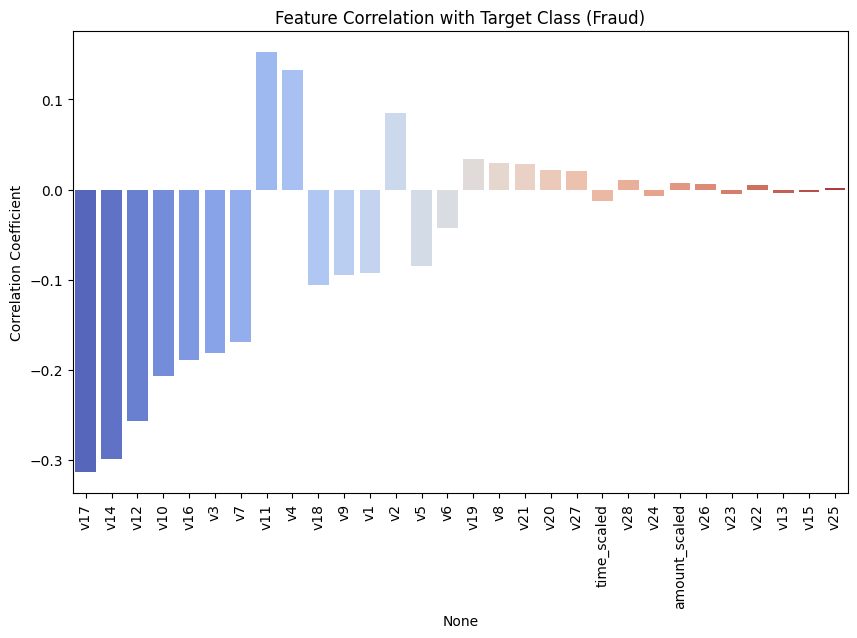

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.index, y=target_corr.values,hue=target_corr.index,legend=False, palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Feature Correlation with Target Class (Fraud)")
plt.ylabel("Correlation Coefficient")
plt.show()

In [39]:
from sklearn.model_selection import cross_val_score

used_features = []
scores = []

for f in target_corr.index:
    used_features.append(f)

    log_temp = LogisticRegression(class_weight='balanced', max_iter=400, random_state=11037)

    # 5-fold CV and F1 score (for imbalance)
    cv_scores = cross_val_score(
        log_temp,
        X_train[used_features],
        y_train,
        cv=cv,
        scoring='f1',
        n_jobs=-1
    )

    mean_score = cv_scores.mean()
    scores.append(mean_score)

    print(f"Added Feature: {f} | F1-Score: {mean_score:.4f}")


Added Feature: v17 | F1-Score: 0.5997
Added Feature: v14 | F1-Score: 0.1247
Added Feature: v12 | F1-Score: 0.1114
Added Feature: v10 | F1-Score: 0.1171
Added Feature: v16 | F1-Score: 0.1198
Added Feature: v3 | F1-Score: 0.1117
Added Feature: v7 | F1-Score: 0.1122
Added Feature: v11 | F1-Score: 0.1111
Added Feature: v4 | F1-Score: 0.1063
Added Feature: v18 | F1-Score: 0.1070
Added Feature: v9 | F1-Score: 0.1069
Added Feature: v1 | F1-Score: 0.1067
Added Feature: v2 | F1-Score: 0.1060
Added Feature: v5 | F1-Score: 0.1034
Added Feature: v6 | F1-Score: 0.1046
Added Feature: v19 | F1-Score: 0.1050
Added Feature: v8 | F1-Score: 0.1111
Added Feature: v21 | F1-Score: 0.1112
Added Feature: v20 | F1-Score: 0.1114
Added Feature: v27 | F1-Score: 0.1100
Added Feature: time_scaled | F1-Score: 0.1129
Added Feature: v28 | F1-Score: 0.1127
Added Feature: v24 | F1-Score: 0.1125
Added Feature: amount_scaled | F1-Score: 0.1130
Added Feature: v26 | F1-Score: 0.1119
Added Feature: v23 | F1-Score: 0.1111
Add

## 🔍 Forward Feature Selection with Logistic Regression

To explore the contribution of individual features to model performance, we performed a forward feature selection procedure. At each step, we added the next most-correlated feature to the model and computed the mean F1-score using 5-fold cross-validation.

The results show:

- The first feature alone achieves a very high F1-score (~0.65).
- Adding additional features leads to a sharp performance drop and does not improve results significantly.
- This suggests that the first feature captures most of the fraud signal for a linear model like Logistic Regression.

This behavior is expected because:
- Most features are PCA-transformed and orthogonal, meaning they are uncorrelated by construction.
- Logistic Regression may struggle to separate classes in PCA space.

The plot below illustrates this trend.


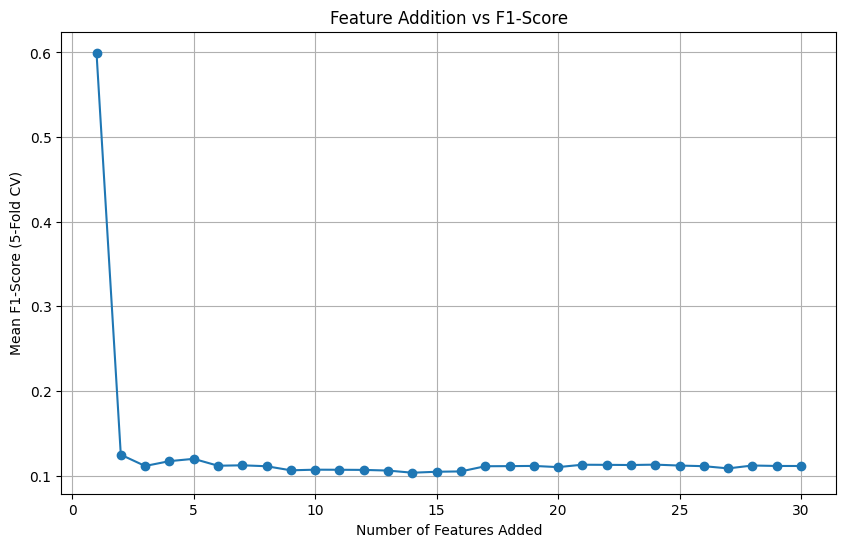

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(scores) + 1), scores, marker='o')
plt.title("Feature Addition vs F1-Score")
plt.xlabel("Number of Features Added")
plt.ylabel("Mean F1-Score (5-Fold CV)")
plt.grid(True)
plt.show()

In [61]:
log_v17_clf = LogisticRegression(class_weight='balanced', max_iter=400, random_state=11037)
# perform cross-validation with full metrics on v17 only
cv_v17_results = cross_validate(
    log_v17_clf,
    X_train[['v17']], y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False
)
results_v17_df = pd.DataFrame(cv_v17_results).mean()

In [42]:
results_v17_df

,0
fit_time,0.247208
score_time,0.087405
test_accuracy,0.998427
test_precision,0.522537
test_recall,0.706316
test_f1,0.599657
test_roc_auc,0.794113
test_pr_auc,0.368949
test_balanced_accuracy,0.852615


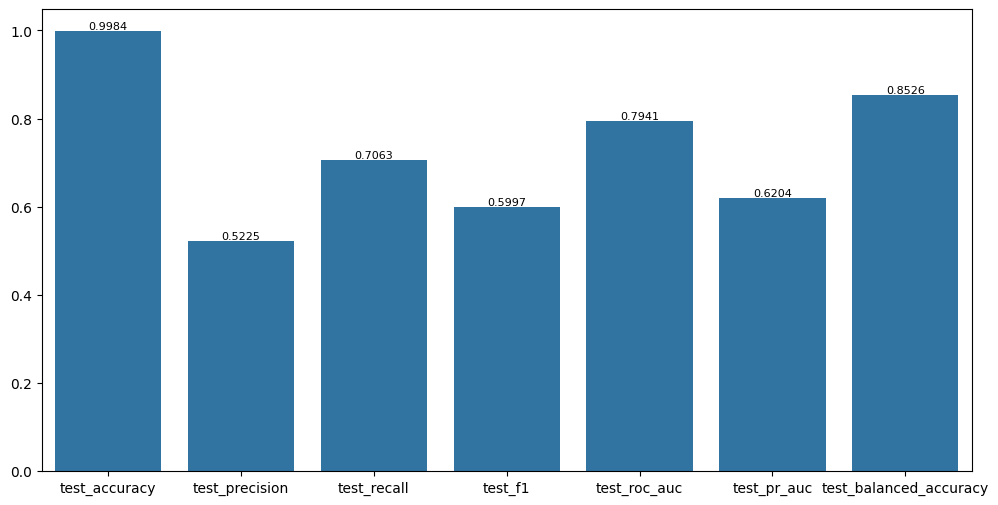

In [62]:
plt.figure(figsize=(12,6))
base_model_scores_barplot = sns.barplot(results_v17_df.loc['test_accuracy':])


for patch in base_model_scores_barplot.patches:
    height = patch.get_height()
    if height > 0:
        base_model_scores_barplot.annotate(f'{height:.4f}',  # formatting
            (patch.get_x() + patch.get_width() / 2, height), # setting each coordinate to be on the patch
            ha='center', va='bottom', fontsize=8, rotation=0) # position related to the patch cordinate, right above and center


plt.show()

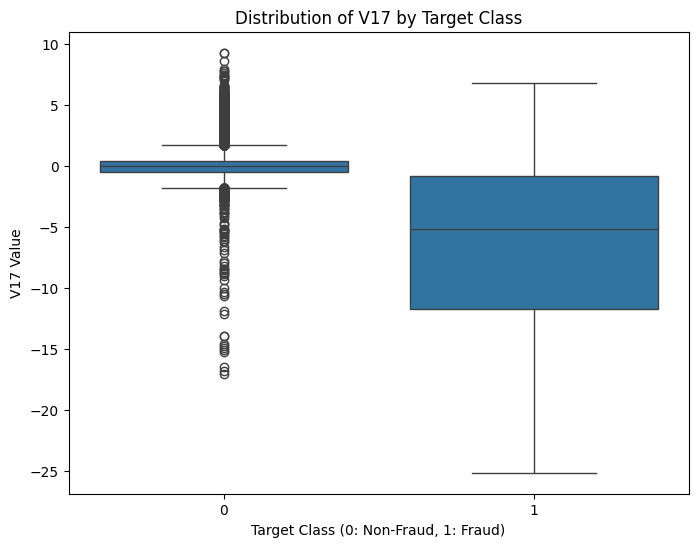

In [63]:


plt.figure(figsize=(8, 6))
sns.boxplot(x=y_train, y=X_train['v17'])
plt.title("Distribution of V17 by Target Class")
plt.xlabel("Target Class (0: Non-Fraud, 1: Fraud)")
plt.ylabel("V17 Value")
plt.show()

## 🌲 Random Forest Classifier With Feature Importances

To explore non-linear patterns and potential feature interactions, we train a Random Forest Classifier using all PCA-transformed features and the scaled `Amount` and `Time`.  

Random Forest is a tree-based ensemble method that:  
- Handles imbalanced datasets better than linear models.  
- Provides a direct estimate of feature importances.  

We train the model using 5-fold cross-validation and compute the same evaluation metrics as before.


In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# ⚙️ Random Forest model
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',  # Handle class imbalance
    random_state=11037,
    n_jobs=-1
)

# 📊 Evaluate model
rf_cv_results = cross_validate(
    rf_clf,
    X_train,
    y_train,
    cv=5,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

# 📄 Display mean CV scores
for metric, scores in rf_cv_results.items():
    if metric.startswith("test_"):
        print(f"{metric}: {scores.mean():.6f}")

results_rand_tree_df = pd.DataFrame(rf_cv_results)


test_accuracy: 0.999498
test_precision: 0.954939
test_recall: 0.732737
test_f1: 0.828568
test_roc_auc: 0.949611
test_pr_auc: 0.833339
test_balanced_accuracy: 0.866340


In [68]:
results_rand_tree_df = pd.DataFrame(rf_cv_results).mean(numeric_only=True)
results_rand_tree_df.loc['test_accuracy':]

,0
test_accuracy,0.999498
test_precision,0.954939
test_recall,0.732737
test_f1,0.828568
test_roc_auc,0.949611
test_pr_auc,0.833339
test_balanced_accuracy,0.866340


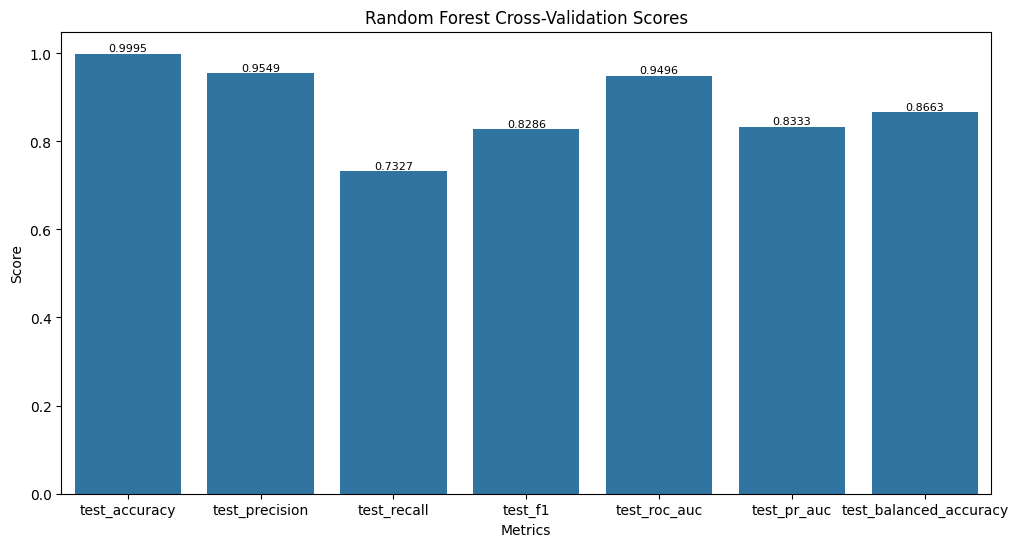

In [69]:
plt.figure(figsize=(12, 6))

# 📊 Bar plot for Random Forest metrics
rand_tree_scores_barplot = sns.barplot(data=results_rand_tree_df.loc['test_accuracy':])

# Annotate bars with their values
for patch in rand_tree_scores_barplot.patches:
    height = patch.get_height()
    rand_tree_scores_barplot.annotate(
        f'{height:.4f}',  # Format value
        (patch.get_x() + patch.get_width() / 2, height),  # Center annotation
        ha='center', va='bottom', fontsize=8, color='black'
    )

plt.title("Random Forest Cross-Validation Scores")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.show()


In [48]:
results_rand_tree_df = pd.DataFrame(rf_cv_results).mean(numeric_only=True)
results_rand_tree_df

,0
fit_time,191.132952
score_time,1.009117
test_accuracy,0.999498
test_precision,0.954939
test_recall,0.732737
test_f1,0.828568
test_roc_auc,0.949611
test_average_precision,0.833339
test_balanced_accuracy,0.866340


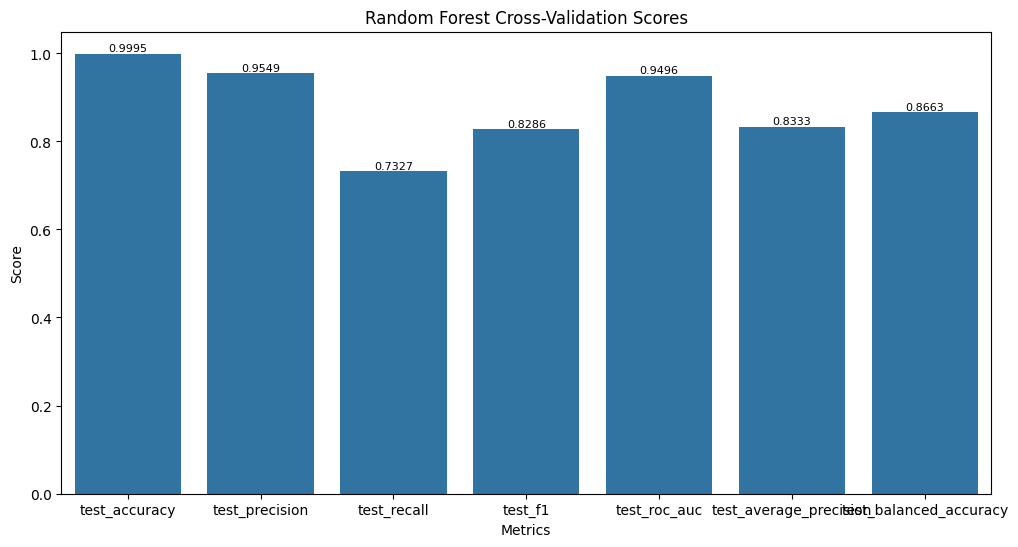

In [49]:
plt.figure(figsize=(12, 6))

# 📊 Bar plot for Random Forest metrics
rand_tree_scores_barplot = sns.barplot(data=results_rand_tree_df.loc['test_accuracy':])

# Annotate bars with their values
for patch in rand_tree_scores_barplot.patches:
    height = patch.get_height()
    rand_tree_scores_barplot.annotate(
        f'{height:.4f}',  # Format value
        (patch.get_x() + patch.get_width() / 2, height),  # Center annotation
        ha='center', va='bottom', fontsize=8, color='black'
    )

plt.title("Random Forest Cross-Validation Scores")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.show()

In [50]:
import numpy as np

importances = np.mean(
    [estimator.feature_importances_ for estimator in rf_cv_results['estimator']],
    axis=0
)

# 📊 Sort and display
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
feature_importances

,0
v14,0.179122
v10,0.147381
v4,0.132642
v12,0.125501
v11,0.070061
v17,0.053701
v3,0.037241
v7,0.031188
v16,0.031136
v2,0.020191


/tmp/ipython-input-51-1651492526.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")


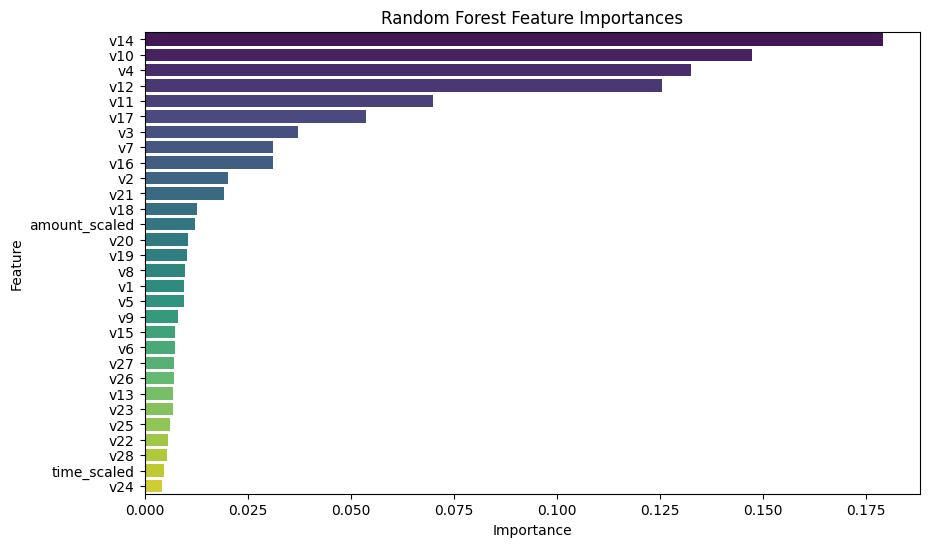

In [51]:
# 📉 Plot Feature Importances
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
